# Autonomous Drone with AI Navigation + Orchestrator Agent (Simulation)

This Colab-ready notebook demonstrates an **Autonomous Drone Navigation** project without any hardware. It uses a simple 2D simulator (top-down grid world), an expert rule-based controller to generate training data, a learned policy (MLP) as the Control Agent, and an **Orchestrator Agent** that runs the full pipeline end-to-end.

What this notebook includes:
- Synthetic environment & expert demonstrations (DataAgent)
- Policy training (ModelAgent)
- Evaluation and visualization (EvalAgent)
- OrchestratorAgent: single entrypoint to run everything


# **Imports & Setup**

In [39]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
from dataclasses import dataclass
print('Imports OK')


Imports OK


# **DataAgent: lightweight 2D grid simulator and expert trajectory generator**

In [40]:
class GridWorld:
    def __init__(self, size=(32,32), n_obstacles=80, seed=42):
        self.size = size
        self.n_obstacles = n_obstacles
        self.seed = seed
        self._rng = random.Random(seed)
        self.reset_world()

    def reset_world(self):
        h,w = self.size
        self.grid = np.zeros(self.size, dtype=np.uint8)
        # place random obstacles
        for _ in range(self.n_obstacles):
            x = self._rng.randrange(h)
            y = self._rng.randrange(w)
            self.grid[x,y] = 1
        # ensure borders passable
        self.grid[0,:] = 0
        self.grid[:,0] = 0
        self.grid[-1,:] = 0
        self.grid[:,-1] = 0

    def sample_free(self):
        h,w = self.size
        while True:
            x = self._rng.randrange(h)
            y = self._rng.randrange(w)
            if self.grid[x,y]==0:
                return (x,y)

    def is_free(self, pos):
        x,y = pos
        h,w = self.size
        if x<0 or y<0 or x>=h or y>=w:
            return False
        return self.grid[x,y]==0

    def render(self, agent_pos=None, goal=None, path=None, figsize=(6,6)):
        h,w = self.size
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(self.grid.T, origin='lower', cmap='Greys')
        if path is not None:
            xs = [p[0] for p in path]
            ys = [p[1] for p in path]
            ax.plot(xs, ys, '-o', color='cyan')
        if agent_pos is not None:
            ax.plot(agent_pos[0], agent_pos[1], 'ro')
        if goal is not None:
            ax.plot(goal[0], goal[1], 'gx')
        ax.set_xlim(-0.5, h-0.5)
        ax.set_ylim(-0.5, w-0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.show()

def neighbors(pos):
    x,y = pos
    for dx,dy in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
        yield (x+dx, y+dy)

def heuristic(a,b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def astar(gridworld, start, goal, max_steps=2000):
    # Simple A* on the grid, returns path or None
    import heapq
    open_set = []
    heapq.heappush(open_set, (0+heuristic(start,goal), 0, start, None))
    came_from = {}
    gscore = {start: 0}
    closed = set()
    while open_set:
        f, g, current, parent = heapq.heappop(open_set)
        if current in closed:
            continue
        came_from[current] = parent
        if current == goal:
            # reconstruct
            path = []
            cur = current
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            return list(reversed(path))
        closed.add(current)
        for nb in neighbors(current):
            if not gridworld.is_free(nb):
                continue
            tentative_g = g + heuristic(current, nb)
            if tentative_g < gscore.get(nb, float('inf')):
                gscore[nb] = tentative_g
                heapq.heappush(open_set, (tentative_g + heuristic(nb, goal), tentative_g, nb, current))
    return None

class DataAgent:
    def __init__(self, world_size=(32,32), n_obstacles=80, seed=42):
        self.world_size = world_size
        self.n_obstacles = n_obstacles
        self.seed = seed
        self.world = GridWorld(size=world_size, n_obstacles=n_obstacles, seed=seed)

    def generate_episode(self, max_steps=200):
        # sample start and goal and compute expert path with A*
        start = self.world.sample_free()
        goal = self.world.sample_free()
        path = astar(self.world, start, goal)
        if path is None or len(path) < 2:
            return None
        # create transitions: state -> action (action = next delta)
        X = []
        y = []
        for i in range(len(path)-1):
            s = path[i]
            nxt = path[i+1]
            dx = nxt[0]-s[0]
            dy = nxt[1]-s[1]
            X.append([s[0], s[1], goal[0], goal[1]])
            y.append([dx, dy])
        return {'start': start, 'goal': goal, 'path': path, 'X': np.array(X), 'y': np.array(y)}

    def generate_dataset(self, n_episodes=200):
        allX = []
        ally = []
        episodes = []
        attempts = 0
        while len(episodes) < n_episodes and attempts < n_episodes*5:
            ep = self.generate_episode()
            attempts += 1
            if ep is None:
                continue
            episodes.append(ep)
            allX.append(ep['X'])
            ally.append(ep['y'])
        if len(allX)==0:
            raise RuntimeError('No episodes generated')
        X = np.vstack(allX)
        y = np.vstack(ally)
        return X, y, episodes

print('DataAgent defined')


DataAgent defined


# **ModelAgent: trains a simple MLP classifier to predict next-move direction (one of 8)**

In [41]:
from sklearn.preprocessing import LabelEncoder
class ModelAgent:
    def __init__(self):
        self.model = None
        self.le = LabelEncoder()

    def fit(self, X, y):
        # convert dx,dy to discrete label
        labels = [ (int(int(a[0])), int(int(a[1]))) for a in y ]
        dirs = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
        dir2idx = {d:i for i,d in enumerate(dirs)}
        yidx = [dir2idx.get(tuple(l), 0) for l in labels]
        yidx = np.array(yidx)
        X_train, X_val, y_train, y_val = train_test_split(X, yidx, test_size=0.2, random_state=42)
        clf = MLPClassifier(hidden_layer_sizes=(64,64), max_iter=300, random_state=42)
        clf.fit(X_train, y_train)
        self.model = clf
        self.dirs = dirs
        preds = clf.predict(X_val)
        acc = accuracy_score(y_val, preds)
        print(f'Model trained. Val acc: {acc:.3f}')
        return acc

    def predict(self, X):
        idx = self.model.predict(np.array(X))
        return [ self.dirs[i] for i in idx ]

print('ModelAgent defined')


ModelAgent defined


# **EvalAgent: simulate episodes using the learned policy and compute success/collision/trajectory error**

In [42]:
class EvalAgent:
    def __init__(self, world):
        self.world = world

    def run_episode(self, start, goal, policy, max_steps=500):
        pos = start
        traj = [pos]
        for t in range(max_steps):
            X = [ [pos[0], pos[1], goal[0], goal[1]] ]
            move = policy.predict(X)[0]
            new = (pos[0]+move[0], pos[1]+move[1])
            if not self.world.is_free(new):
                # collision -> fail
                return {'success': False, 'collision': True, 'traj': traj}
            pos = new
            traj.append(pos)
            if pos == goal:
                return {'success': True, 'collision': False, 'traj': traj}
        return {'success': False, 'collision': False, 'traj': traj}

    def evaluate(self, episodes, policy):
        results = []
        for ep in episodes:
            r = self.run_episode(ep['start'], ep['goal'], policy)
            results.append(r)
        n = len(results)
        success = sum(1 for r in results if r['success']) / n
        coll = sum(1 for r in results if r['collision']) / n
        avg_len = np.mean([len(r['traj']) for r in results])
        return {'n': n, 'success_rate': success, 'collision_rate': coll, 'avg_len': avg_len, 'results': results}

    def make_animation(self, ep, policy, filename='demo.gif'):
        # animate one episode using the learned policy
        fig, ax = plt.subplots(figsize=(4,4))
        ax.imshow(self.world.grid.T, origin='lower', cmap='Greys')
        agent_dot, = ax.plot([], [], 'ro')
        goal_dot, = ax.plot(ep['goal'][0], ep['goal'][1], 'gx')
        traj_x, traj_y = [], []

        def init():
            agent_dot.set_data([], [])
            return (agent_dot,)

        frames = []
        pos = ep['start']
        frames.append(pos)
        for _ in range(200):
            X = [[pos[0], pos[1], ep['goal'][0], ep['goal'][1]]]
            move = policy.predict(X)[0]
            new = (pos[0]+move[0], pos[1]+move[1])
            if not self.world.is_free(new):
                break
            pos = new
            frames.append(pos)
            if pos == ep['goal']:
                break

        def update(i):
            p = frames[i]
            agent_dot.set_data([p[0]], [p[1]])
            return (agent_dot,)

        anim = animation.FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=True)
        try:
            anim.save(filename, writer=PillowWriter(fps=6))

            print(f'Animation saved to {filename}')
        except Exception as e:
            print('Failed to save animation:', e)
        plt.close(fig)

print('EvalAgent defined')


EvalAgent defined


# **ReportAgent + OrchestratorAgent**

In [43]:
from datetime import datetime
class ReportAgent:
    def __init__(self, out_dir='outputs'):
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)

    def save_report(self, summary, filename='report.txt'):
        path = os.path.join(self.out_dir, filename)
        with open(path, 'w') as f:
            f.write('Autonomous Drone - Simulation Report\n')
            f.write(f'Generated: {datetime.utcnow().isoformat()} UTC\n\n')
            for k,v in summary.items():
                if k!='results':
                    f.write(f'{k}: {v}\n')
        print('Report saved to', path)
        return path

class OrchestratorAgent:
    def __init__(self, seed=42):
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)
        self.data_agent = None
        self.model_agent = None
        self.eval_agent = None
        self.report_agent = ReportAgent()

    def run(self, n_episodes=200, n_train_eps=150):
        print('Orchestrator: generating data...')
        self.data_agent = DataAgent(world_size=(32,32), n_obstacles=80, seed=self.seed)
        X,y,episodes = self.data_agent.generate_dataset(n_episodes)
        print('Data generated:', X.shape, y.shape)

        print('Training model...')
        self.model_agent = ModelAgent()
        acc = self.model_agent.fit(X, y)

        print('Evaluating...')
        self.eval_agent = EvalAgent(self.data_agent.world)
        # evaluate on episodes (use a subset)
        eval_eps = episodes[-40:]
        summary = self.eval_agent.evaluate(eval_eps, self.model_agent)
        print('Summary:', summary)

        report_path = self.report_agent.save_report(summary)
        # save animation for first eval episode
        gif_path = os.path.join(self.report_agent.out_dir, 'demo.gif')
        self.eval_agent.make_animation(eval_eps[0], self.model_agent, filename=gif_path)
        return {'summary': summary, 'report': report_path, 'demo': gif_path}

print('OrchestratorAgent defined')


OrchestratorAgent defined


# **Run the Orchestrator Agent**

In [44]:
if __name__ == '__main__':
    orch = OrchestratorAgent(seed=42)
    out = orch.run(n_episodes=220)
    print('Run complete. Outputs:')
    print(out)


Orchestrator: generating data...
Data generated: (3242, 4) (3242, 2)
Training model...
Model trained. Val acc: 0.778
Evaluating...
Summary: {'n': 40, 'success_rate': 0.3, 'collision_rate': 0.675, 'avg_len': np.float64(19.6), 'results': [{'success': True, 'collision': False, 'traj': [(5, 25), (5, 24), (5, 23), (4, 22), (3, 21), (3, 20), (2, 19), (2, 18), (1, 17), (1, 16), (0, 16)]}, {'success': True, 'collision': False, 'traj': [(7, 29), (8, 28), (9, 27), (10, 26), (11, 25), (12, 24), (13, 23), (14, 22), (15, 21), (16, 20), (17, 19), (18, 18), (19, 18), (20, 17), (21, 17), (22, 16), (23, 16)]}, {'success': False, 'collision': True, 'traj': [(24, 23), (23, 22)]}, {'success': False, 'collision': True, 'traj': [(30, 1), (29, 2), (28, 3), (27, 4), (26, 5), (25, 6), (24, 7), (23, 8), (22, 9), (22, 10), (21, 11), (21, 12)]}, {'success': False, 'collision': True, 'traj': [(4, 29), (5, 29), (6, 29), (7, 29), (8, 29), (9, 29)]}, {'success': True, 'collision': False, 'traj': [(7, 8), (6, 7), (5, 

/tmp/ipython-input-1237150736.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f'Generated: {datetime.utcnow().isoformat()} UTC\n\n')


Report saved to outputs/report.txt
Animation saved to outputs/demo.gif
Run complete. Outputs:
{'summary': {'n': 40, 'success_rate': 0.3, 'collision_rate': 0.675, 'avg_len': np.float64(19.6), 'results': [{'success': True, 'collision': False, 'traj': [(5, 25), (5, 24), (5, 23), (4, 22), (3, 21), (3, 20), (2, 19), (2, 18), (1, 17), (1, 16), (0, 16)]}, {'success': True, 'collision': False, 'traj': [(7, 29), (8, 28), (9, 27), (10, 26), (11, 25), (12, 24), (13, 23), (14, 22), (15, 21), (16, 20), (17, 19), (18, 18), (19, 18), (20, 17), (21, 17), (22, 16), (23, 16)]}, {'success': False, 'collision': True, 'traj': [(24, 23), (23, 22)]}, {'success': False, 'collision': True, 'traj': [(30, 1), (29, 2), (28, 3), (27, 4), (26, 5), (25, 6), (24, 7), (23, 8), (22, 9), (22, 10), (21, 11), (21, 12)]}, {'success': False, 'collision': True, 'traj': [(4, 29), (5, 29), (6, 29), (7, 29), (8, 29), (9, 29)]}, {'success': True, 'collision': False, 'traj': [(7, 8), (6, 7), (5, 6), (4, 5), (3, 4), (2, 3), (2, 2)

# **View Reports**

In [45]:
print(open('outputs/report.txt').read())

Autonomous Drone - Simulation Report
Generated: 2025-12-01T08:33:19.560899 UTC

n: 40
success_rate: 0.3
collision_rate: 0.675
avg_len: 19.6



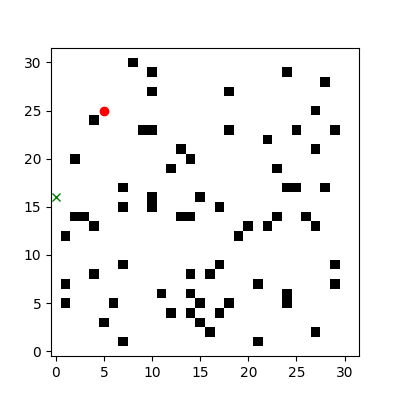

In [46]:
from IPython.display import Image, display
display(Image('outputs/demo.gif'))

#### This project is designed to be fully reproducible without hardware and demonstrates an **Orchestrator Agent** chaining data generation, model training, evaluation, and reporting.